### Disclaimer

The following notebook was compiled for the course 'Geostatistics' at Ghent University (lecturer-in-charge: Prof. Dr. Ellen Van De Vijver; teaching assistant: Pablo De Weerdt). It consists of notebook snippets created by Michael Pyrcz. The code and markdown (text) snippets were edited specifically for this course, using the 'Jura data set' (Goovaerts, 1997) as example in the practical classes. Some new code snippets are also included to cover topics which were not found in the Geostastpy package demo books.

This notebook is for educational purposes.<br> 

Guidelines for getting started were adapted from the 'Environmental Soil Sensing' course at Ghent University (lecturer-in-charge: Prof. Dr. Philippe De Smedt).<br> 

The Jura data set was taken from: Goovaerts P., 1997. Geostatistics for Natural Resources Evaluation. Oxford University Press.

**Don't forget to save a copy on your Google drive before starting**

You can also 'mount' your Google Drive in Google colab to directly access your Drive folders (e.g. to access data, previous notebooks etc.)

Do not hesitate to contact us for questions or feel free to ask questions during the practical sessions.

# Geostatistics: Introduction to geostatistical data analysis with Python

In [2]:
# Import required packages for setup
# -------------------------------------------- #

import sys
import os

In [3]:
sys.path.append(r'c:\Users\pdweerdt\Documents\Repos\draft_E_I002454_Geostatistics')

In [ ]:
#  Clone the repository and add it to the path
if 'google.colab' in sys.modules:
    !git clone https://github.com/SENSE-UGent/E_I002454_Geostatistics.git
    sys.path.append('/content/E_I002454_Geostatistics') #Default location in Google Colab after cloning
else:
    # if you are not using Google Colab, change the path to the location of the repository
    sys.path.append(r'c:\Users\pdweerdt\Documents\Repos\E_I002454_Geostatistics')

# Import the setup function
from Utils.setup import check_and_install_packages

# Read the requirements.txt file
if 'google.colab' in sys.modules:
    requirements_path = '/content/E_I002454_Geostatistics/Utils/requirements.txt'
else:
    requirements_path = 'c:/Users/pdweerdt/Documents/Repos/E_I002454_Geostatistics/Utils/requirements.txt'

with open(requirements_path) as f:
    required_packages = f.read().splitlines()

# Check and install packages
check_and_install_packages(required_packages)

#### Load Required libraries

In [4]:
import geostatspy
import geostatspy.GSLIB as GSLIB                              # GSLIB utilities, visualization and wrapper
import geostatspy.geostats as geostats                        # if this raises an error, you might have to check your numba isntallation   
print('GeostatsPy version: ' + str(geostatspy.__version__))   # these notebooks were tested with GeostatsPy version: 0.0.72

GeostatsPy version: 0.0.72


In [5]:
from Utils.func import add_grid

In [ ]:
# there was a small bug in the original kb2d_locations code from the geostatspy package
# we have fixed this bug in the Utils.func module

from Utils.func import kb2d_locations_v2

We will also need some standard packages. These should have been installed.

In [6]:
from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)
                                   
import numpy as np                                            # ndarrays for gridded data
                                       
import pandas as pd                                           # DataFrames for tabular data

import matplotlib.pyplot as plt                               # for plotting

from scipy import stats                                       # summary statistics

plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements

ignore_warnings = True                                        # ignore warnings?
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')

from IPython.utils import io                                  # mute output from simulation

seed = 42                                                     # random number seed

### Optional libraries

These are not required to run the given version of this practical exercise, but might be useful if you want to extend this notebook with more code.

In [7]:
#  import math library
import math

import cmath

In [8]:
from scipy.stats import pearsonr                              # Pearson product moment correlation
from scipy.stats import spearmanr                             # spearman rank correlation    
                                   
import seaborn as sns                                         # advanced plotting

import matplotlib as mpl                                        

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib.colors import ListedColormap 
import matplotlib.ticker as mtick 
import matplotlib.gridspec as gridspec

### Set the Working Directory

Do this to simplify subsequent reads and writes (avoid including the full address each time). 

##### For use in Google Colab

Run the following cell if you automatically want to get the data from the repository and store it on your Google Colab drive

In [ ]:
# change the working directory to the cloned repository

os.chdir('E_I002454_Geostatistics')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

##### For local use

Only run the following cell if you have the data locally stored.

In [9]:
# set the working directory, place an r in front to address special characters
os.chdir(r'C:\\Users\\pdweerdt\\OneDrive - UGent\\I002454 - Geostatistics\\AY 2024-2025\\Practicals')

# get the current directory and store it as a variable

cd = os.getcwd()
print("Current Working Directory is " , cd)

Current Working Directory is  C:\Users\pdweerdt\OneDrive - UGent\I002454 - Geostatistics\AY 2024-2025\Practicals


## Make a Simple, Small Example

The following are the basic parameters for the demonstration.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

Then simply assume some data, and a variogram model.

This will allow for very fast iteration with the kB2D program.

### Loading tabular data

In [16]:
# Here you can adjust the relative Path to the data folder

os.chdir(r'C:\Users\pdweerdt\OneDrive - UGent\I002454 - Geostatistics\AY 2024-2025\Practicals\Practical 7\Pract7')
cd = os.getcwd()

In [18]:
file_name = '//kripar.dat'

df = GSLIB.GSLIB2Dataframe(cd + file_name) # read the data

# Convert all columns to integers
df = df.astype(int)

df.head()

,X,Y,V,nr
0,61,139,477,1
1,63,140,696,2
2,64,129,227,3
3,68,128,646,4
4,71,140,606,5


#### Visualizing Tabular Data with Location Maps

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

Let's add the plotting parameters.

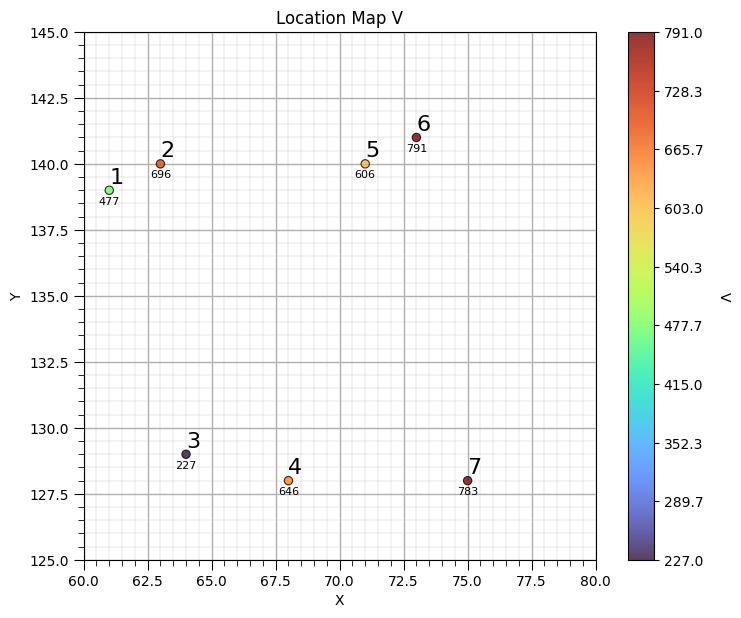

In [13]:
xmin = int((df.X.min() // 5) * 5); xmax = int((df.X.max() // 5 + 1) * 5)  # range of x values floored and ceiled to closest half-decade
ymin = int((df.Y.min() // 5) * 5); ymax = int((df.Y.max() // 5 + 1) * 5)  # range of y values floored and ceiled to closest half-decade
min_feat = int(df.V.min()); max_feat = int(df.V.max())                   # range of feature values

cmap_rainb = plt.cm.turbo  # similar to what is shown on the slides

GSLIB.locmap_st(df, 'X', 'Y', 'V', xmin, xmax, ymin, ymax, min_feat, max_feat, ('Location Map ' + 'V'), 'X', 'Y', 'V', cmap_rainb); add_grid()

# Add annotations for each point
for _, row in df.iterrows():
    plt.annotate(str(row['V']), (row['X'], row['Y']), textcoords="offset points", xytext=(0, -10), ha= 'center'
    , fontsize=8, color='black')

for _, row in df.iterrows():
    plt.annotate(str(row['nr']), (row['X'], row['Y']), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=16, color='black')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)
plt.show()

## Variogram model

In [ ]:
nug = 0; nst = 1    # 2 nest structure variogram model parameters
it1 = 2;            # 1=spherical, 2=exponential, 3=gaussian
cc1 = 10; 
azi1 = 0; 
hmaj1 = 15; hmin1 = 15

if nst==2:

    it2 = 2; # prefereably same as it1
    cc2 = 4.2; # sill contribution of the second structure in major direction
    azi2 = 45; # direction with maximum spatial continuity (perpendicular to the major axis)
    hmaj2 = 1000; hmin2 = 1.1

else:

    it2= np.nan
    cc2= np.nan
    azi2= np.nan
    hmaj2= np.nan
    hmin2= np.nan

vario_mod = GSLIB.make_variogram(nug,nst,
                                it1,cc1,azi1,hmaj1,hmin1,
                                it2,cc2,azi2,hmaj2,hmin2
                                ) # make model object

In [ ]:
nx = 1; ny = 1; xsiz = 0; ysiz = 0; xmn = 65; ymn = 137; nxdis = 1; nydis = 1
ndmin = 2; ndmax = 15; radius = 3
ktype = 1 # ordinary kriging
skmean = 2 # in case of simple kriging, the mean is known

kmap, vmap = kb2d(df,'x','y','vr',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,vario_mod)

  Estimated   10000 blocks 
      average   1.984891698010888  variance  0.01224913076801526


# Example code

Let's visualize the resulting kriging estimates with the data plotted and the kriging variance map.

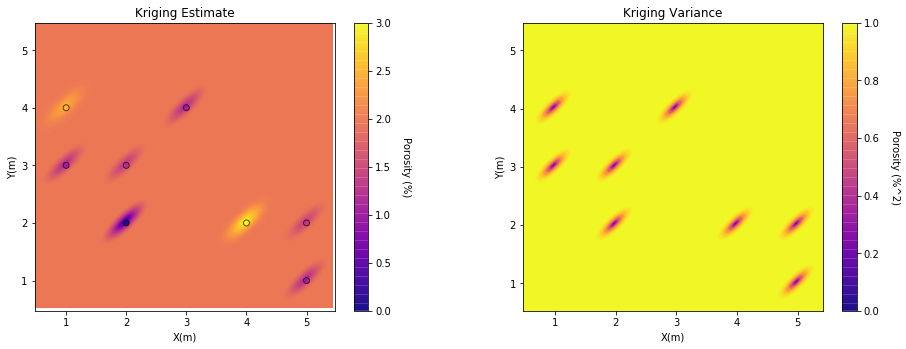

In [ ]:
cmap = plt.cm.plasma                        # color min and max and using the plasma color map

xmin = xmn - xsiz/2; ymin = ymn - ysiz/2;
xmax = xmin + xsiz * nx; ymax = ymin + ysiz * ny

plt.subplot(121)
locpix_st(kmap,xmin,xmax,ymin,ymax,xsiz,0.0,3.0,df,'x','y','vr','Kriging Estimate','X(m)','Y(m)','Porosity (%)',cmap)

plt.subplot(122)
pixelplt_st(vmap,xmin,xmax,ymin,ymax,xsiz,0.0,1.0,'Kriging Variance','X(m)','Y(m)','Porosity (%^2)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3)
plt.show()